written by Hazwan Adhikara

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

import re
import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

## Data Preparation

In [2]:
train = pd.read_csv('./data/train.csv', encoding='latin-1')
test = pd.read_csv('./data/test.csv', encoding='latin-1')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

display(train.head())
display(test.head())

Train shape: (27481, 10)
Test shape: (3532, 8)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


,textID,text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Kmï¿½),Density (P/Kmï¿½)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,morning,0-20,Afghanistan,38928346,652860.0,60
1,96d74cb729,Shanghai is also really exciting (precisely -...,noon,21-30,Albania,2877797,27400.0,105
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",night,31-45,Algeria,43851044,2381740.0,18
3,01082688c6,happy bday!,morning,46-60,Andorra,77265,470.0,164
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
train.info()

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


,Population -2020,Land Area (Km²),Density (P/Km²)
count,2.748100e+04,2.748100e+04,27481.000000
mean,4.018497e+07,6.621730e+05,357.686583
std,1.504946e+08,1.807425e+06,2013.750702
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


Missing Values Summary:
               Missing Values  Percentage
text                        1    0.003639
selected_text               1    0.003639


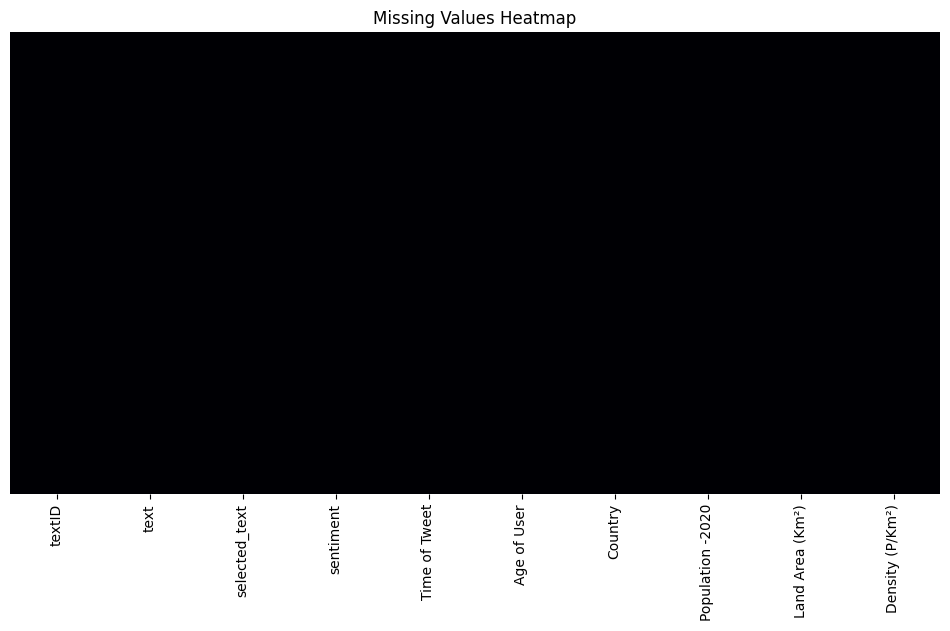

In [4]:
# Menampilkan jumlah missing values per kolom
missing_values = train.isnull().sum()
missing_percentage = (missing_values / len(train)) * 100

# Gabungkan jumlah dan persentase missing values
missing_train = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_train = missing_train[missing_train['Missing Values'] > 0]

print("Missing Values Summary:")
print(missing_train.sort_values(by='Missing Values', ascending=False))

# Visualisasi heatmap missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cmap='inferno', cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [5]:
bad_idx = train[train['text'].isna() & train['selected_text'].isna()].index
print("Missing Value Rows:", bad_idx.tolist())

train = train.dropna(subset=['text', 'selected_text']).reset_index(drop=True)

Missing Value Rows: [314]


In [6]:
train.isna().sum()
print("Train shape:", train.shape)

Train shape: (27480, 10)


## Exploratory Data Analysis

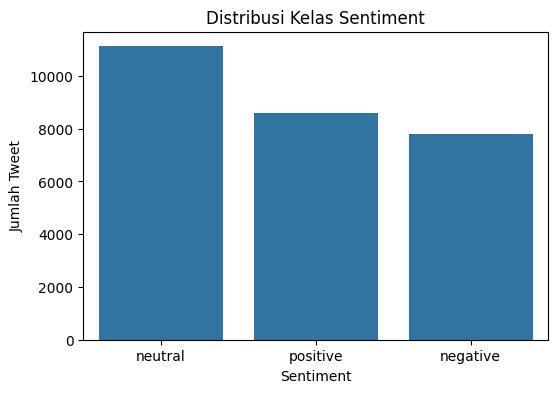

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='sentiment', order=train['sentiment'].value_counts().index)
plt.title('Distribusi Kelas Sentiment')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Sentiment')
plt.show()


           char_len      word_len
count  27480.000000  27480.000000
mean      68.354949     12.902875
std       35.624417      6.925938
min        3.000000      1.000000
25%       39.000000      7.000000
50%       64.000000     12.000000
75%       97.000000     18.000000
max      159.000000     33.000000


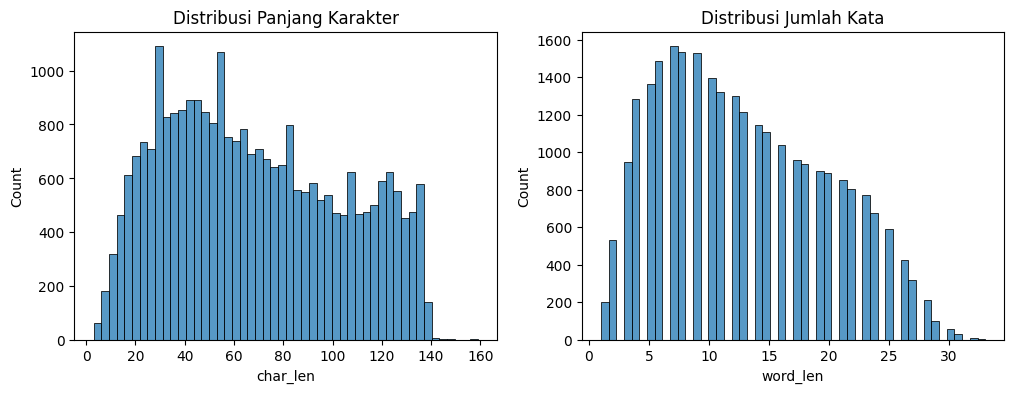

In [8]:
# Hitung jumlah kata & karakter
train['char_len'] = train['text'].str.len()
train['word_len'] = train['text'].str.split().str.len()

# Statistik panjang
print(train[['char_len','word_len']].describe())

# Visualisasi
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(train['char_len'], bins=50, ax=axes[0])
axes[0].set_title('Distribusi Panjang Karakter')
sns.histplot(train['word_len'], bins=50, ax=axes[1])
axes[1].set_title('Distribusi Jumlah Kata')
plt.show()



Top 20 kata untuk sentiment neutral:
[('i', 6207), ('to', 4152), ('the', 3554), ('a', 2552), ('it', 2026), ('my', 2016), ('you', 1958), ('and', 1876), ('in', 1606), ('is', 1515), ('for', 1439), ('s', 1288), ('on', 1283), ('of', 1251), ('t', 1241), ('but', 1145), ('me', 1129), ('that', 1061), ('have', 1012), ('just', 923)]

Top 20 kata untuk sentiment negative:
[('i', 5792), ('to', 2900), ('the', 2463), ('my', 2043), ('a', 1825), ('it', 1642), ('and', 1595), ('is', 1349), ('t', 1274), ('in', 1134), ('you', 1053), ('that', 1022), ('me', 1003), ('so', 985), ('s', 954), ('m', 918), ('of', 908), ('for', 881), ('not', 822), ('on', 802)]

Top 20 kata untuk sentiment positive:
[('i', 4669), ('the', 3015), ('to', 2980), ('a', 2417), ('you', 2338), ('it', 1738), ('and', 1694), ('my', 1488), ('s', 1395), ('for', 1337), ('day', 1259), ('is', 1145), ('in', 1076), ('good', 1066), ('of', 996), ('that', 931), ('love', 889), ('happy', 858), ('so', 834), ('have', 831)]


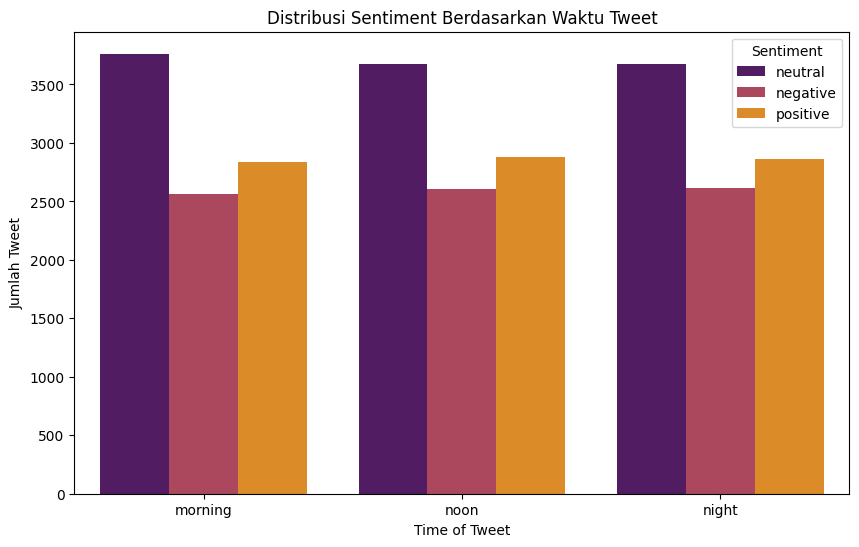

In [9]:
def get_top_n(words, n=20):
    all_words = ' '.join(words).lower()
    tokens = re.findall(r'\b\w+\b', all_words)
    counter = Counter(tokens)
    return counter.most_common(n)

for sentiment in train['sentiment'].unique():
    texts = train.loc[train['sentiment']==sentiment, 'text']
    top20 = get_top_n(texts, 20)
    print(f"\nTop 20 kata untuk sentiment {sentiment}:")
    print(top20)

# Analisis hubungan antara waktu tweet dan sentiment
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='Time of Tweet', hue='sentiment', palette="inferno")
plt.title('Distribusi Sentiment Berdasarkan Waktu Tweet')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Time of Tweet')
plt.legend(title='Sentiment')
plt.show()

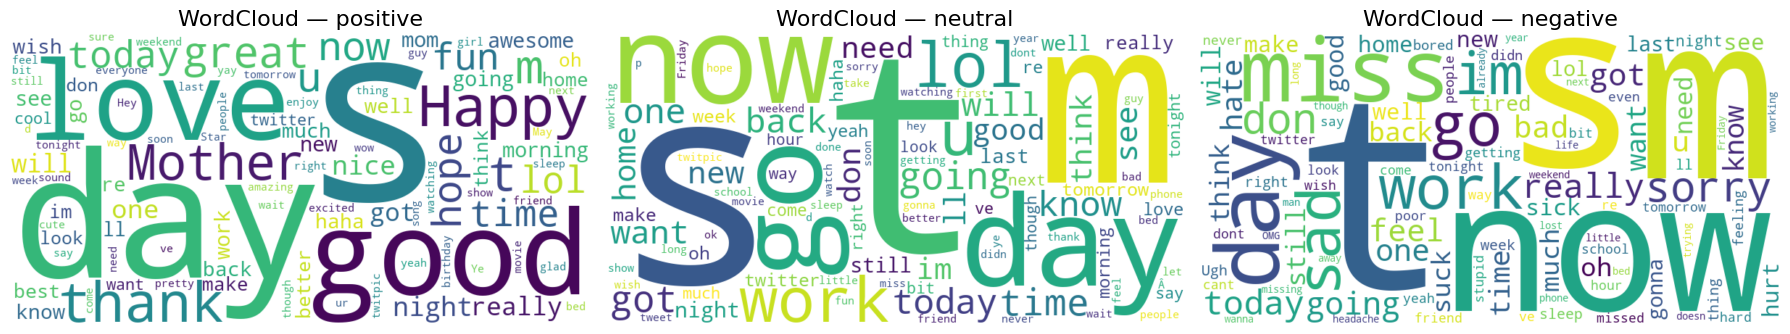

In [10]:
pos_text = ' '.join(train[train['sentiment']=='positive']['text'].dropna().tolist())
neu_text = ' '.join(train[train['sentiment']=='neutral']['text'].dropna().tolist())
neg_text = ' '.join(train[train['sentiment']=='negative']['text'].dropna().tolist())

texts = {
    'positive': pos_text,
    'neutral':  neu_text,
    'negative': neg_text
}

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for ax, (sentiment, txt) in zip(axes, texts.items()):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        collocations=False
    ).generate(txt)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'WordCloud — {sentiment}', fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()


  Age of User  Age_of_User_Code
0        0-20                 1
1       21-30                 2
2       31-45                 3
3       46-60                 4
4       60-70                 5
5      70-100                 6


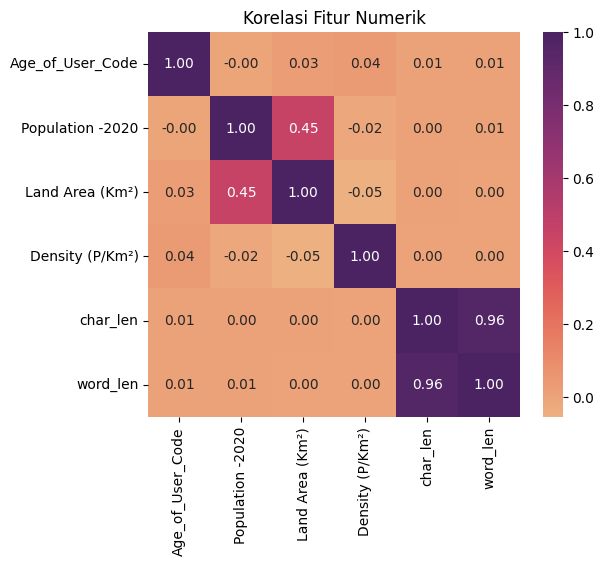

In [11]:
age_mapping = {
    '0-20':  1,
    '21-30': 2,
    '31-45': 3,
    '46-60': 4,
    '60-70': 5,
    '70-100': 6
}

train['Age_of_User_Code'] = train['Age of User'].map(age_mapping)

print(train[['Age of User', 'Age_of_User_Code']].drop_duplicates())

num_cols = [
    'Age_of_User_Code',
    'Population -2020',
    'Land Area (Km²)',
    'Density (P/Km²)',
    'char_len',
    'word_len'
]
corr = train[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='flare')
plt.title('Korelasi Fitur Numerik')
plt.show()
